In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. LOAD AND MERGE
df_ml = pd.read_csv('data/lake_flood_ml_ready.csv')
df_topo = pd.read_csv('data/lake_slope_elevation.csv')
df = df_ml.merge(df_topo[['name', 'elevation', 'slope']], on='name', how='left')

# 2. FEATURE ENGINEERING
# WIBI Proxy: Detects hard debris in dry lake beds
df['wibi_proxy'] = df['encroachment_pct'] * (1 - (df['static_water_ha'] / df['potential_ha']))
# Urban Stress: Runoff pressure (Imperviousness x Catchment Flow)
df['urban_stress'] = df['impervious_fraction'] * df['flow_accumulation_km2']
# CSR: Catchment-to-Storage Ratio
df['csr_ratio'] = df['flow_accumulation_km2'] / (df['potential_ha'] + 0.01)

# 3. DEFINE FEATURE PILLARS
rain_feats = ['max_3day_rain_mm', 'peak_30min_intensity_mm']
modification_feats = ['impervious_fraction', 'wibi_proxy', 'urban_stress']
topology_feats = ['potential_ha', 'flow_accumulation_km2', 'csr_ratio', 'elevation', 'slope']

X_cols = rain_feats + modification_feats + topology_feats
df['risk_label'] = (df['sar_flood_freq_pct'] > 25).astype(int)
df_ml_final = df.dropna(subset=X_cols + ['risk_label'])

# 4. TRAIN MODEL
X = df_ml_final[X_cols]
y = df_ml_final['risk_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 5. EXPORT PREDICTIONS
test_results = df_ml_final.loc[X_test.index, ['name', 'sar_flood_freq_pct', 'risk_label']].copy()
test_results['predicted_risk'] = model.predict(X_test)
test_results.to_csv('data/final_flood_risk_with_topo.csv', index=False)

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.79      0.85      0.81        13

    accuracy                           0.85        33
   macro avg       0.84      0.85      0.84        33
weighted avg       0.85      0.85      0.85        33



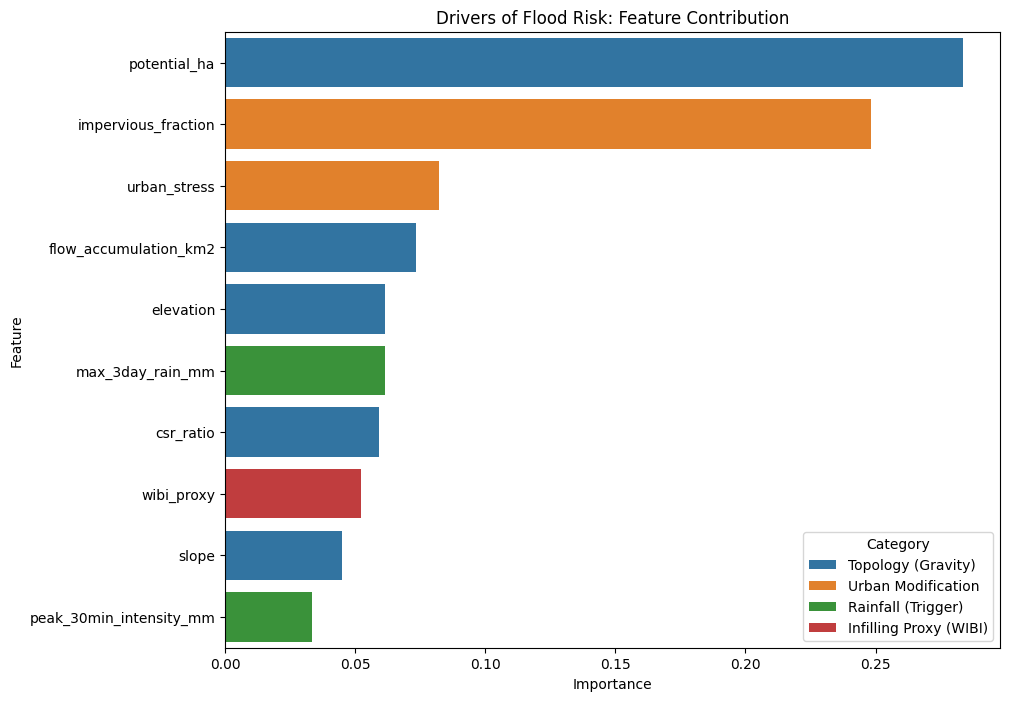

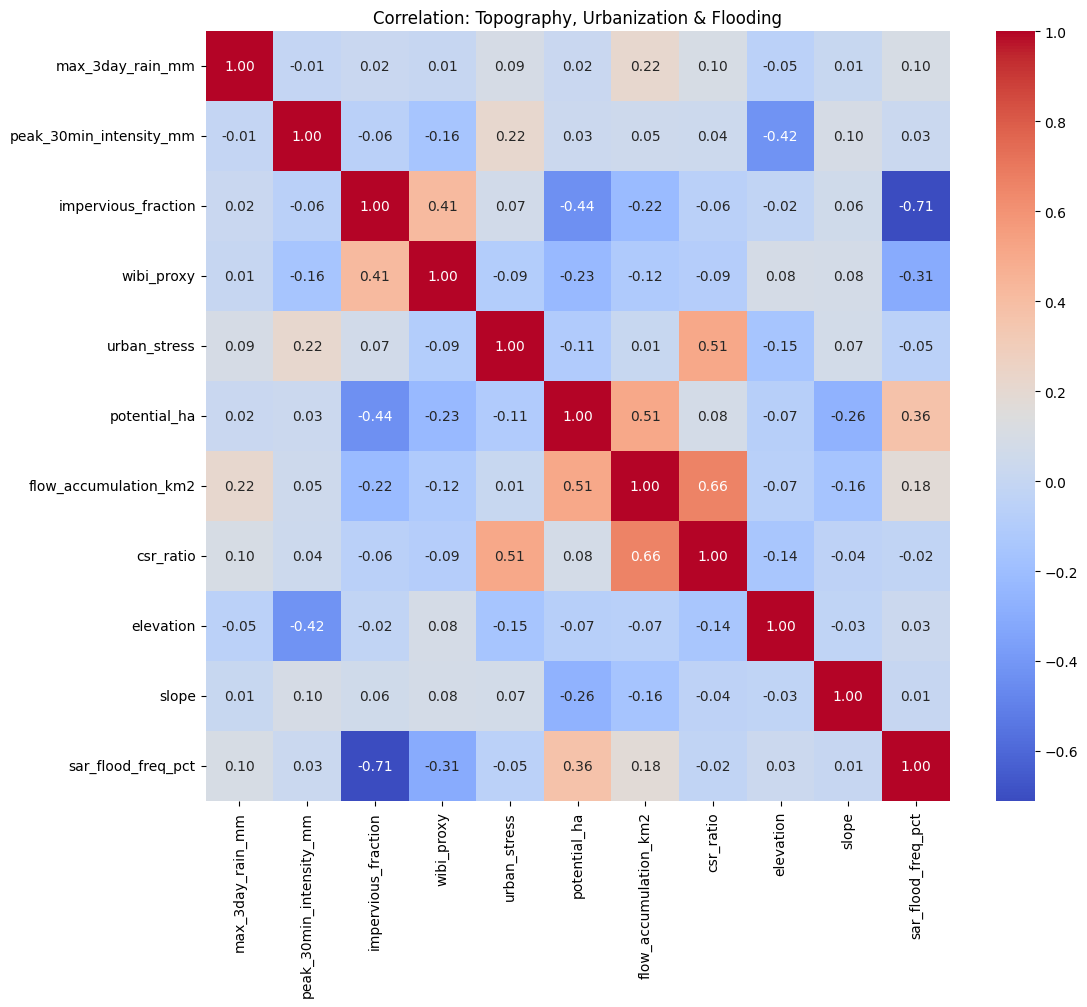

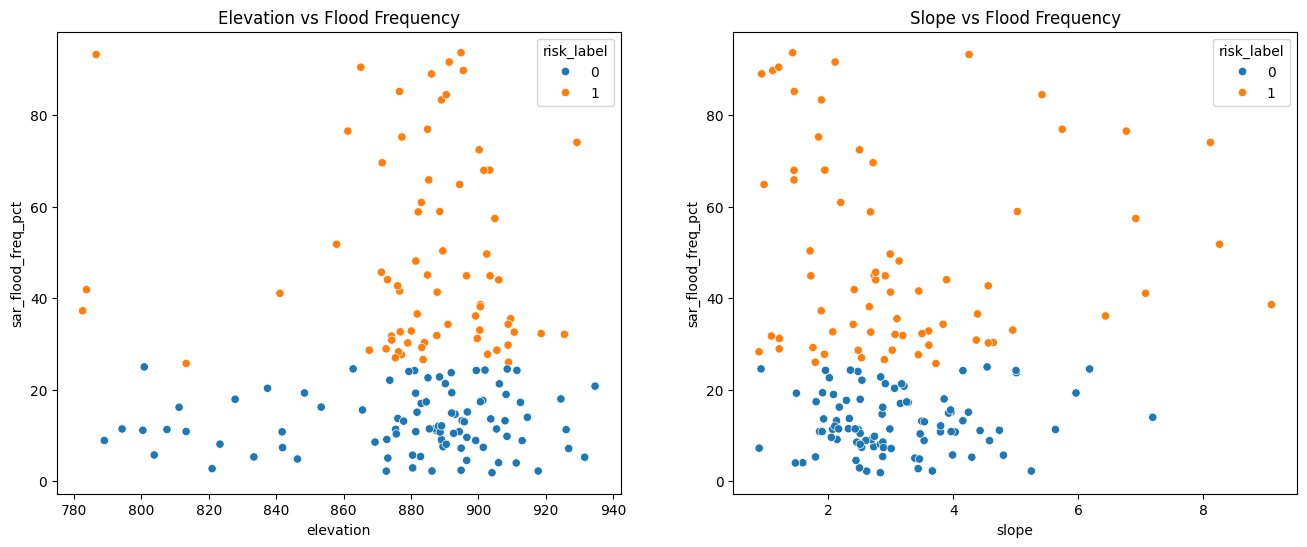

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. LOAD AND PREPARE DATA
df_ml = pd.read_csv('data/lake_flood_ml_ready.csv')
df_topo = pd.read_csv('data/lake_slope_elevation.csv')
df = df_ml.merge(df_topo[['name', 'elevation', 'slope']], on='name', how='left')

# Feature Engineering
df['wibi_proxy'] = df['encroachment_pct'] * (1 - (df['static_water_ha'] / df['potential_ha']))
df['urban_stress'] = df['impervious_fraction'] * df['flow_accumulation_km2']
df['csr_ratio'] = df['flow_accumulation_km2'] / (df['potential_ha'] + 0.01)

# Categorization for Analysis
rain_feats = ['max_3day_rain_mm', 'peak_30min_intensity_mm']
modification_feats = ['impervious_fraction', 'wibi_proxy', 'urban_stress']
topology_feats = ['potential_ha', 'flow_accumulation_km2', 'csr_ratio', 'elevation', 'slope']

X_cols = rain_feats + modification_feats + topology_feats
category_map = {
    'max_3day_rain_mm': 'Rainfall (Trigger)',
    'peak_30min_intensity_mm': 'Rainfall (Trigger)',
    'impervious_fraction': 'Urban Modification',
    'wibi_proxy': 'Infilling Proxy (WIBI)',
    'urban_stress': 'Urban Modification',
    'potential_ha': 'Topology (Gravity)',
    'flow_accumulation_km2': 'Topology (Gravity)',
    'csr_ratio': 'Topology (Gravity)',
    'elevation': 'Topology (Gravity)',
    'slope': 'Topology (Gravity)'
}

# 2. MODEL TRAINING
df['risk_label'] = (df['sar_flood_freq_pct'] > 25).astype(int)
df_final = df.dropna(subset=X_cols + ['risk_label'])
X = df_final[X_cols]; y = df_final['risk_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 3. VISUALIZATION: Feature Importance
feat_imp = pd.DataFrame({'Feature': X_cols, 'Importance': model.feature_importances_})
feat_imp['Category'] = feat_imp['Feature'].map(category_map)
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp, x='Importance', y='Feature', hue='Category', dodge=False)
plt.title('Drivers of Flood Risk: Feature Contribution')
plt.savefig('flood_feature_importance.png')

# 4. VISUALIZATION: Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_final[X_cols + ['sar_flood_freq_pct']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation: Topography, Urbanization & Flooding')
plt.savefig('flood_correlation_heatmap.png')

# 5. VISUALIZATION: Topographic Impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=df_final, x='elevation', y='sar_flood_freq_pct', hue='risk_label', ax=ax1)
ax1.set_title('Elevation vs Flood Frequency')
sns.scatterplot(data=df_final, x='slope', y='sar_flood_freq_pct', hue='risk_label', ax=ax2)
ax2.set_title('Slope vs Flood Frequency')
plt.savefig('topography_impact.png')

print(classification_report(y_test, model.predict(X_test)))